# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [52]:
!pip install prettytable

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import nltk
import re
import os
import pickle
from tqdm import tqdm
import seaborn
import numpy as np
from prettytable import PrettyTable

In [1]:
import pandas as pd
data = pd.read_csv('preprocessed_data.csv',nrows = 50000)

In [3]:
y = data["project_is_approved"].values #calculating y
X = data.drop(["project_is_approved"], axis =1) #using X to predict y

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [7]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
#Test-Train 80-20 Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify = y)

<h2>1.3.1 Make Data Model Ready: encoding eassay, and project_title using Bag of Words</h2>

In [14]:
#Encoding essay using Count Vectorizer
vectorizer = CountVectorizer(min_df = 10, ngram_range = (1,4), max_features = 5000)
vectorizer.fit(X_train["essay"].values)
essay_feature_bow = vectorizer.get_feature_names()
X_train_essay_bow = vectorizer.transform(X_train["essay"].values)
X_test_essay_bow = vectorizer.transform(X_test["essay"].values)
print("After BoW encoding of essay : ")
print("Features are : ", essay_feature_bow)

#Encoding teacher_prefix using Count Vectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train["teacher_prefix"].values)
teacher_prefix_feature_bow = vectorizer.get_feature_names()
X_train_teacher_prefix_bow = vectorizer.transform(X_train["teacher_prefix"].values)
X_test_teacher_prefix_bow = vectorizer.transform(X_test["teacher_prefix"].values)
print("After BoW encoding of teacher_prefix : ")
print("Features are : ", teacher_prefix_feature_bow)

#Encoding project_grade_category using Count Vectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train["project_grade_category"].values)
project_grade_category_feature_bow = vectorizer.get_feature_names()
X_train_project_grade_category_bow = vectorizer.transform(X_train["project_grade_category"].values)
X_test_project_grade_category_bow = vectorizer.transform(X_test["project_grade_category"].values)
print("After BoW encoding of project_grade_category : ")
print("Features are : ", project_grade_category_feature_bow)

#Encoding school_state using Count Vectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train["school_state"].values)
school_state_feature_bow = vectorizer.get_feature_names()
X_train_school_state_bow = vectorizer.transform(X_train["school_state"].values)
X_test_school_state_bow = vectorizer.transform(X_test["school_state"].values)
print("After BoW encoding of school_state : ")
print("Features are : ", school_state_feature_bow)

#Encoding clean_categories using Count Vectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train["clean_categories"].values)
clean_categories_feature_bow = vectorizer.get_feature_names()
X_train_clean_categories_bow = vectorizer.transform(X_train["clean_categories"].values)
X_test_clean_categories_bow = vectorizer.transform(X_test["clean_categories"].values)
print("After BoW encoding of clean_categories : ")
print("Features are : ", clean_categories_feature_bow)

#Encoding clean_subcategories using Count Vectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train["clean_subcategories"].values)
clean_subcategories_feature_bow = vectorizer.get_feature_names()
X_train_clean_subcategories_bow = vectorizer.transform(X_train["clean_subcategories"].values)
X_test_clean_subcategories_bow = vectorizer.transform(X_test["clean_subcategories"].values)
print("After BoW encoding of clean_subcategories : ")
print("Features are : ", clean_subcategories_feature_bow)

After BoW encoding of essay : 
Features are :  ['000', '10', '100', '100 free', '100 percent', '100 students', '100 students receive', '100 students receive free', '11', '12', '12th', '13', '14', '15', '16', '17', '18', '1st', '1st grade', '1st graders', '20', '2016', '2016 2017', '2017', '21', '21st', '21st century', '21st century learners', '21st century skills', '22', '23', '24', '25', '25 students', '26', '28', '2nd', '2nd grade', '2nd graders', '30', '30 students', '3d', '3rd', '3rd grade', '3rd graders', '40', '45', '4th', '4th 5th', '4th grade', '4th graders', '50', '50 students', '500', '5th', '5th grade', '5th grade students', '5th graders', '60', '60 minutes', '60 minutes day', '60 students', '600', '6th', '6th grade', '6th graders', '70', '70 students', '75', '75 students', '7th', '7th 8th', '7th grade', '80', '80 students', '85', '8th', '8th grade', '8th grade students', '8th graders', '90', '90 students', '95', '98', '99', '9th', 'abilities', 'ability', 'ability learn', 'a

After BoW encoding of teacher_prefix : 
Features are :  ['dr', 'mr', 'mrs', 'ms', 'teacher']
After BoW encoding of project_grade_category : 
Features are :  ['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
After BoW encoding of school_state : 
Features are :  ['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
After BoW encoding of clean_categories : 
Features are :  ['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
After BoW encoding of clean_subcategories : 
Features are :  ['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'e

<h2>1.3.2 Make Data Model Ready: encoding eassay, and project_title using Tfidf</h2>

In [15]:
#Encoding essay using Tfidf Vectorizer
vectorizer = TfidfVectorizer(min_df = 10, ngram_range = (1,4), max_features = 5000)
vectorizer.fit(X_train["essay"].values)
essay_feature_tf = vectorizer.get_feature_names()
X_train_essay_tf = vectorizer.transform(X_train["essay"].values)
X_test_essay_tf = vectorizer.transform(X_test["essay"].values)
print("After tfidf encoding of essay : ")
print("Top 100 features are : ", essay_feature_tf[:100])

#Encoding teacher_prefix using Tfidf Vectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train["teacher_prefix"].values)
teacher_prefix_feature_tf = vectorizer.get_feature_names()
X_train_teacher_prefix_tf = vectorizer.transform(X_train["teacher_prefix"].values)
X_test_teacher_prefix_tf = vectorizer.transform(X_test["teacher_prefix"].values)
print("After tfidf encoding of teacher_prefix : ")
print("Features are : ", teacher_prefix_feature_tf)

#Encoding project_grade_category using Tfidf Vectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train["project_grade_category"].values)
project_grade_category_feature_tf = vectorizer.get_feature_names()
X_train_project_grade_category_tf = vectorizer.transform(X_train["project_grade_category"].values)
X_test_project_grade_category_tf = vectorizer.transform(X_test["project_grade_category"].values)
print("After tfidf encoding of project_grade_category : ")
print("Features are : ", project_grade_category_feature_tf)

#Encoding school_state using Tfidf Vectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train["school_state"].values)
school_state_feature_tf = vectorizer.get_feature_names()
X_train_school_state_tf = vectorizer.transform(X_train["school_state"].values)
X_test_school_state_tf = vectorizer.transform(X_test["school_state"].values)
print("After tfidf encoding of school_state : ")
print("Features are : ", school_state_feature_tf)

#Encoding clean_categories using Tfidf Vectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train["clean_categories"].values)
clean_categories_feature_tf = vectorizer.get_feature_names()
X_train_clean_categories_tf = vectorizer.transform(X_train["clean_categories"].values)
X_test_clean_categories_tf = vectorizer.transform(X_test["clean_categories"].values)
print("After tfidf encoding of clean_categories : ")
print("Features are : ", clean_categories_feature_tf)

#Encoding clean_subcategories using Tfidf Vectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train["clean_subcategories"].values)
clean_subcategories_feature_tf = vectorizer.get_feature_names()
X_train_clean_subcategories_tf = vectorizer.transform(X_train["clean_subcategories"].values)
X_test_clean_subcategories_tf = vectorizer.transform(X_test["clean_subcategories"].values)
print("After tfidf encoding of clean_subcategories : ")
print("Features are : ", clean_subcategories_feature_tf)

After tfidf encoding of essay : 
Top 100 features are :  ['000', '10', '100', '100 free', '100 percent', '100 students', '100 students receive', '100 students receive free', '11', '12', '12th', '13', '14', '15', '16', '17', '18', '1st', '1st grade', '1st graders', '20', '2016', '2016 2017', '2017', '21', '21st', '21st century', '21st century learners', '21st century skills', '22', '23', '24', '25', '25 students', '26', '28', '2nd', '2nd grade', '2nd graders', '30', '30 students', '3d', '3rd', '3rd grade', '3rd graders', '40', '45', '4th', '4th 5th', '4th grade', '4th graders', '50', '50 students', '500', '5th', '5th grade', '5th grade students', '5th graders', '60', '60 minutes', '60 minutes day', '60 students', '600', '6th', '6th grade', '6th graders', '70', '70 students', '75', '75 students', '7th', '7th 8th', '7th grade', '80', '80 students', '85', '8th', '8th grade', '8th grade students', '8th graders', '90', '90 students', '95', '98', '99', '9th', 'abilities', 'ability', 'ability 

<h2>1.4 Make Data Model Ready: encoding numerical features using Normalizer</h2>

In [16]:
#Normalizing Price
normalizer = Normalizer()
normalizer.fit(X_train["price"].values.reshape(-1,1))
X_train_price_normalized = normalizer.transform(X_train["price"].values.reshape(-1,1))
X_test_price_normalized = normalizer.transform(X_test["price"].values.reshape(-1,1))
print("Price Normalized : \nTrain features : ", X_train_price_normalized.shape, y_train.shape, "\nTrain features : ", X_test_price_normalized.shape, y_test.shape )

#Normalizing teacher_number_of_previously_posted_projects
normalizer = Normalizer()
normalizer.fit(X_train["teacher_number_of_previously_posted_projects"].values.reshape(-1,1))
X_train_teacher_number_of_previously_posted_projects_normalized = normalizer.transform(X_train["teacher_number_of_previously_posted_projects"].values.reshape(-1,1))
X_test_teacher_number_of_previously_posted_projects_normalized = normalizer.transform(X_test["teacher_number_of_previously_posted_projects"].values.reshape(-1,1))
print("teacher_number_of_previously_posted_projects Normalized : \nTrain features : ", X_train_teacher_number_of_previously_posted_projects_normalized.shape, y_train.shape, "\nTrain features : ", X_test_teacher_number_of_previously_posted_projects_normalized.shape, y_test.shape )    


Price Normalized : 
Train features :  (40000, 1) (40000,) 
Train features :  (10000, 1) (10000,)
teacher_number_of_previously_posted_projects Normalized : 
Train features :  (40000, 1) (40000,) 
Train features :  (10000, 1) (10000,)


<h2>1.5 Merging All Vectorized Features</h2>

In [21]:
from scipy.sparse import hstack

X_train_bow = hstack((X_train_essay_bow, X_train_school_state_bow, X_train_teacher_prefix_bow, X_train_project_grade_category_bow, X_train_clean_categories_bow, X_train_clean_subcategories_bow, X_train_price_normalized, X_train_teacher_number_of_previously_posted_projects_normalized)).tocsr()
X_test_bow = hstack((X_test_essay_bow, X_test_school_state_bow, X_test_teacher_prefix_bow, X_test_project_grade_category_bow, X_test_clean_categories_bow, X_test_clean_subcategories_bow, X_test_price_normalized, X_test_teacher_number_of_previously_posted_projects_normalized)).tocsr()
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

X_train_tf = hstack((X_train_essay_tf, X_train_school_state_tf, X_train_teacher_prefix_tf, X_train_project_grade_category_tf, X_train_clean_categories_tf, X_train_clean_subcategories_tf, X_train_price_normalized, X_train_teacher_number_of_previously_posted_projects_normalized)).tocsr()
X_test_tf = hstack((X_test_essay_tf, X_test_school_state_tf, X_test_teacher_prefix_tf, X_test_project_grade_category_tf, X_test_clean_categories_tf, X_test_clean_subcategories_tf, X_test_price_normalized, X_test_teacher_number_of_previously_posted_projects_normalized)).tocsr()
print(X_train_tf.shape, y_train.shape)
print(X_test_tf.shape, y_test.shape)

(40000, 5101) (40000,)
(10000, 5101) (10000,)
(40000, 5101) (40000,)
(10000, 5101) (10000,)


<h2>1.6 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

<h2>1.6.1 Training</h2>

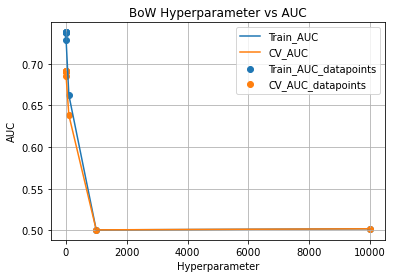

MultinomialNB(alpha=0.01)
The best Hyperparameter alpha for BoW using GridSearch is :  0.01


In [27]:
#Hyper parameter tuning on BoW
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

tuning_model = MultinomialNB()
parameters = {"alpha":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]} #using values as suggested
classifier = GridSearchCV(tuning_model, parameters, cv = 5, scoring = "roc_auc", return_train_score = True, n_jobs = -1)
classifier.fit(X_train_bow, y_train)

bow_results = pd.DataFrame.from_dict(classifier.cv_results_)
bow_results = bow_results.sort_values(["param_alpha"])
bow_train_auc = bow_results["mean_train_score"]
bow_train_auc_std = bow_results["std_train_score"]
bow_cv_auc = bow_results["mean_test_score"]
bow_cv_auc_std = bow_results["std_test_score"]
bow_k = bow_results["param_alpha"] 

#ref:https://stackoverflow.com/a/48803361/4084039
plt.plot(bow_k, bow_train_auc, label = "Train_AUC")
plt.plot(bow_k, bow_cv_auc, label = "CV_AUC")
plt.scatter(bow_k, bow_train_auc, label = "Train_AUC_datapoints")
plt.scatter(bow_k, bow_cv_auc, label = "CV_AUC_datapoints")
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("BoW Hyperparameter vs AUC")
plt.grid()
plt.show()
bow_results
print(classifier.best_estimator_)
best_alpha_of_bow = classifier.best_estimator_.alpha
print("The best Hyperparameter alpha for BoW using GridSearch is : ", best_alpha_of_bow)



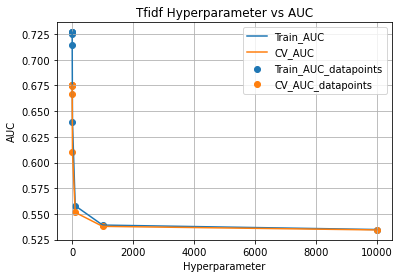

MultinomialNB(alpha=0.0001)
The best Hyperparameter alpha for Tfidf using GridSearch is :  0.0001


In [28]:
#Hyper parameter tuning on Tfidf
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

tuning_model = MultinomialNB()
parameters = {"alpha":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]} #using values as suggested
classifier = GridSearchCV(tuning_model, parameters, cv = 5, scoring = "roc_auc", return_train_score = True, n_jobs = -1)
classifier.fit(X_train_tf, y_train)

tf_results = pd.DataFrame.from_dict(classifier.cv_results_)
tf_results = tf_results.sort_values(["param_alpha"])
tf_train_auc = tf_results["mean_train_score"]
tf_train_auc_std = tf_results["std_train_score"]
tf_cv_auc = tf_results["mean_test_score"]
tf_cv_auc_std = tf_results["std_test_score"]
tf_k = tf_results["param_alpha"] 

#ref:https://stackoverflow.com/a/48803361/4084039
plt.plot(tf_k, tf_train_auc, label = "Train_AUC")
plt.plot(tf_k, tf_cv_auc, label = "CV_AUC")
plt.scatter(tf_k, tf_train_auc, label = "Train_AUC_datapoints")
plt.scatter(tf_k, tf_cv_auc, label = "CV_AUC_datapoints")
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("Tfidf Hyperparameter vs AUC")
plt.grid()
plt.show()
tf_results
print(classifier.best_estimator_)
best_alpha_of_tf = classifier.best_estimator_.alpha
print("The best Hyperparameter alpha for Tfidf using GridSearch is : ", best_alpha_of_tf)



<h2>1.6.2 Testing</h2>

In [30]:
#Creating Prediction Function 
def predict(classifier, data):
    y_pred = []
    loop = data.shape[0] - data.shape[0]%1000
    for i in range(0, loop, 1000):
        y_pred.extend(classifier.predict_proba(data[i:i+1000])[:,1])
    if data.shape[0]%1000!=0:
        y_pred.extend(classifier.predict_proba(data[loop:])[:,1])
    return y_pred

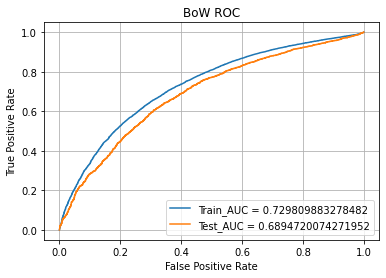

In [31]:
#Testing for BoW
model = MultinomialNB(alpha = best_alpha_of_bow)
model.fit(X_train_bow, y_train)

y_train_pred_bow = predict(model, X_train_bow)
y_test_pred_bow = predict(model, X_test_bow)

train_fpr_bow, train_tpr_bow, train_thresholds_bow = roc_curve(y_train, y_train_pred_bow)
test_fpr_bow, test_tpr_bow, test_thresholds_bow = roc_curve(y_test, y_test_pred_bow)

plt.plot(train_fpr_bow, train_tpr_bow, label = "Train_AUC = "+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label = "Test_AUC = "+str(auc(test_fpr_bow, test_tpr_bow)))

auc_bow = auc(test_fpr_bow, test_tpr_bow)
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BoW ROC")
plt.grid()
plt.show()

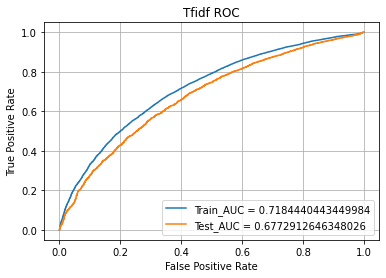

In [32]:
#Testing for Tfidf
model = MultinomialNB(alpha = best_alpha_of_tf)
model.fit(X_train_tf, y_train)

y_train_pred_tf = predict(model, X_train_tf)
y_test_pred_tf = predict(model, X_test_tf)

train_fpr_tf, train_tpr_tf, train_thresholds_tf = roc_curve(y_train, y_train_pred_tf)
test_fpr_tf, test_tpr_tf, test_thresholds_tf = roc_curve(y_test, y_test_pred_tf)

plt.plot(train_fpr_tf, train_tpr_tf, label = "Train_AUC = "+str(auc(train_fpr_tf, train_tpr_tf)))
plt.plot(test_fpr_tf, test_tpr_tf, label = "Test_AUC = "+str(auc(test_fpr_tf, test_tpr_tf)))

auc_tf = auc(test_fpr_tf, test_tpr_tf)
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Tfidf ROC")
plt.grid()
plt.show()

In [46]:
def best_threshold(threshold, tpr, fpr):
    best = threshold[np.argmax(tpr*(1-fpr))] #logic: will return highest value when fpr is low and tpr is high
    return best

def predict_best(proba, threshold): #predicting the value using the best threshold
    prediction = []
    for i in proba:
        if i >= threshold:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction

def plot_confusion_matrix(data): #ref:https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    #print(data.shape)
    dataframe = pd.DataFrame(data, index = [0,1], columns = [0,1])
    print(dataframe, "\n")
    seaborn.cubehelix_palette(8)
    seaborn.set(font_scale = 2)
    dataframe.index.name = "Actual"
    dataframe.columns.name = "Predicted"
    labels = np.array([[{"TN":data[0][0]}, {"FP":data[0][1]}], [{"FN":data[1][0]}, {"TP":data[1][1]}]])
    #print(labels.shape)
    figure, axis = plt.subplots()
    axis = seaborn.heatmap(dataframe, annot = labels, fmt = '', annot_kws = {"size":20}, cbar = False, linecolor = "yellow", linewidths = 0.75, cmap = "PuBu")
    plt.show()

Confusion Matrix for BoW Vectorization Model is : 
************************************************************
      0     1
0  1024   577
1  2917  5482 



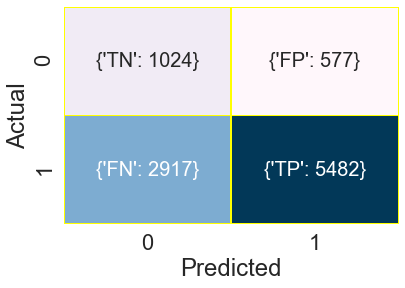

************************************************************************************************************************
************************************************************************************************************************
Confusion Matrix for Tfidf Vectorization Model is : 
************************************************************
      0     1
0   960   641
1  2865  5534 



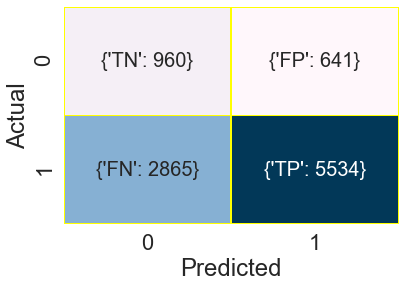

In [47]:
print("Confusion Matrix for BoW Vectorization Model is : ")
print("**"*30)
best_threshold_of_bow = best_threshold(train_thresholds_bow, train_tpr_bow, train_fpr_bow)
confusion_matrix_bow = confusion_matrix(y_test, predict_best(y_test_pred_bow, best_threshold_of_bow))
plot_confusion_matrix(confusion_matrix_bow)
print("**"*60)
print("**"*60)

print("Confusion Matrix for Tfidf Vectorization Model is : ")
print("**"*30)
best_threshold_of_tf = best_threshold(train_thresholds_tf, train_tpr_tf, train_fpr_tf)
confusion_matrix_tf = confusion_matrix(y_test, predict_best(y_test_pred_tf, best_threshold_of_tf))
plot_confusion_matrix(confusion_matrix_tf)

In [48]:
def extract_features(n, d, feature1, feature2, feature3, feature4, feature5, feature6, probability):
    print("The top ", n, " features are : ")
    for i in range(n):
        if d[i]<5000:
            print(i+1, ": Feature ", feature1[d[i]], " belongs to Essay features with ", probability[d[i]], " probability")
        elif 5000<=d[i]<5051:
            print(i+1, ": Feature ", feature2[d[i]-5000], " belongs to School State features with ", probability[d[i]], " probability")
        elif 5051<=d[i]<5056:
            print(i+1, ": Feature ", feature3[d[i]-5051], " belongs to Teacher Prefix features with ", probability[d[i]], " probability")
        elif 5056<=d[i]<5060:
            print(i+1, ": Feature ", feature4[d[i]-5056], " belongs to Project Grade Category features with ", probability[d[i]], " probability")
        elif 5060<=d[i]<5069:
            print(i+1, ": Feature ", feature5[d[i]-5060], " belongs to Clean Categories features with ", probability[d[i]], " probability")
        elif 5069<=d[i]<5099:
            print(i+1, ": Feature ", feature6[d[i]-5069], " belongs to Clean Sub Categories features with ", probability[d[i]], " probability")
        elif d[i]==5099:
            print(i+1, ": Feature belongs to Price features with ", probability[d[i]], " probability")
        else:
            print(i+1, ": Feature belongs to teacher number of previously posted projects features with ", probability[d[i]], " probability")
        

In [49]:
#ref:https://stackoverflow.com/questions/36265930/how-to-sort-in-descending-order-with-numpy
from numpy import argsort
probability = abs(model.feature_log_prob_[1])
feature_index = np.argsort(-probability) # '-' used for descending order
extract_features(10, feature_index, essay_feature_tf, school_state_feature_tf, teacher_prefix_feature_tf, project_grade_category_feature_tf, clean_categories_feature_tf, clean_subcategories_feature_tf, probability)


The top  10  features are : 
1 : Feature  warmth  belongs to Clean Sub Categories features with  22.48460879888919  probability
2 : Feature  care_hunger  belongs to Clean Sub Categories features with  22.48460879888919  probability
3 : Feature  warmth  belongs to Clean Categories features with  22.48460879888919  probability
4 : Feature  care_hunger  belongs to Clean Categories features with  22.48460879888919  probability
5 : Feature  dr  belongs to Teacher Prefix features with  12.175622805467107  probability
6 : Feature  however certainly control experience  belongs to Essay features with  10.687115929656015  probability
7 : Feature  certainly control experience school  belongs to Essay features with  10.661289226772276  probability
8 : Feature  lives however certainly control  belongs to Essay features with  10.659594720378273  probability
9 : Feature  inspire even  belongs to Essay features with  10.65604443201028  probability
10 : Feature  creative positive way hopeful  belongs t

<h1>3. Summary</h1>


In [54]:
table = PrettyTable(["Vectorization Method", "Model", "HyperParameter Tuning", "HyperParameter Value", "AUC Score"])
table.add_row(["Bag of Words", "MultinomialNB", "GridSearchCV", best_alpha_of_bow, auc_bow])
table.add_row(["TFIDF", "MultinomialNB", "GridSearchCV", best_alpha_of_tf, auc_tf])
print(table)
#https://zetcode.com/python/prettytable/

+----------------------+---------------+-----------------------+----------------------+--------------------+
| Vectorization Method |     Model     | HyperParameter Tuning | HyperParameter Value |     AUC Score      |
+----------------------+---------------+-----------------------+----------------------+--------------------+
|     Bag of Words     | MultinomialNB |      GridSearchCV     |         0.01         | 0.6894720074271952 |
|        TFIDF         | MultinomialNB |      GridSearchCV     |        0.0001        | 0.6772912646348026 |
+----------------------+---------------+-----------------------+----------------------+--------------------+
